<a href="https://www.kaggle.com/code/irtazamalik/shoe-sandal-boot-classifier-resnet152v2-acc-97?scriptVersionId=194699159" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# **Imports**

In [1]:
# Common
import os 
import keras
import numpy as np
import pandas as pd
import tensorflow as tf

# Data 
from keras.preprocessing.image import ImageDataGenerator

# Data Viz
import plotly.express as px
import matplotlib.pyplot as plt

# Model 
from keras.models import Sequential, load_model
from keras.layers import GlobalAvgPool2D as GAP, Dense, Dropout

# Transfer Learning Models 
from tensorflow.keras.applications import InceptionV3, Xception, ResNet152V2

# Callbacks 
from keras.callbacks import EarlyStopping, ModelCheckpoint

# **Data**

Let's **load and understand the data.**

In [2]:
root_path = '../input/shoe-vs-sandal-vs-boot-dataset-15k-images/Shoe vs Sandal vs Boot Dataset/'
class_names = sorted(os.listdir(root_path))
class_names

['Boot', 'Sandal', 'Shoe']

In [3]:
n_classes = len(class_names)
print(f"Total Number of Classes : {n_classes}")

Total Number of Classes : 3


The dataset have **3 Classes**, but we are interested to know how the classes are **distributed in the Dataset**.

In [4]:
class_dis = [len(os.listdir(root_path + name)) for name in class_names]
class_dis

[5000, 5000, 5000]

**Amazing !!**, all the classes are **equally distributed** this ensures that model **cannot be biased towards any class**.

In [5]:
fig = px.pie(names=class_names, values=class_dis)
fig.update_layout({'title':{
    'text':'Class Distribution',
    'x':0.5
}})
fig.show()

In [6]:
# Initialize Generator
gen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True, 
    rotation_range=20,
    validation_split=0.2
)

# Load Data
train_ds = gen.flow_from_directory(
    root_path,
    class_mode='binary',
    shuffle=True,
    batch_size=32,
    target_size=(256,256),
    subset="training"
)

valid_ds = gen.flow_from_directory(
    root_path,
    class_mode='binary',
    shuffle=True,
    batch_size=32,
    target_size=(256,256),
    subset="validation"
)

Found 12000 images belonging to 3 classes.
Found 3000 images belonging to 3 classes.


# **Data Viz**

The best way to understand an **Image Dataset** is to have a look at it.

In [7]:
def show_image(image, title=None):
    plt.imshow(image)
    plt.title(title)
    plt.axis('off')

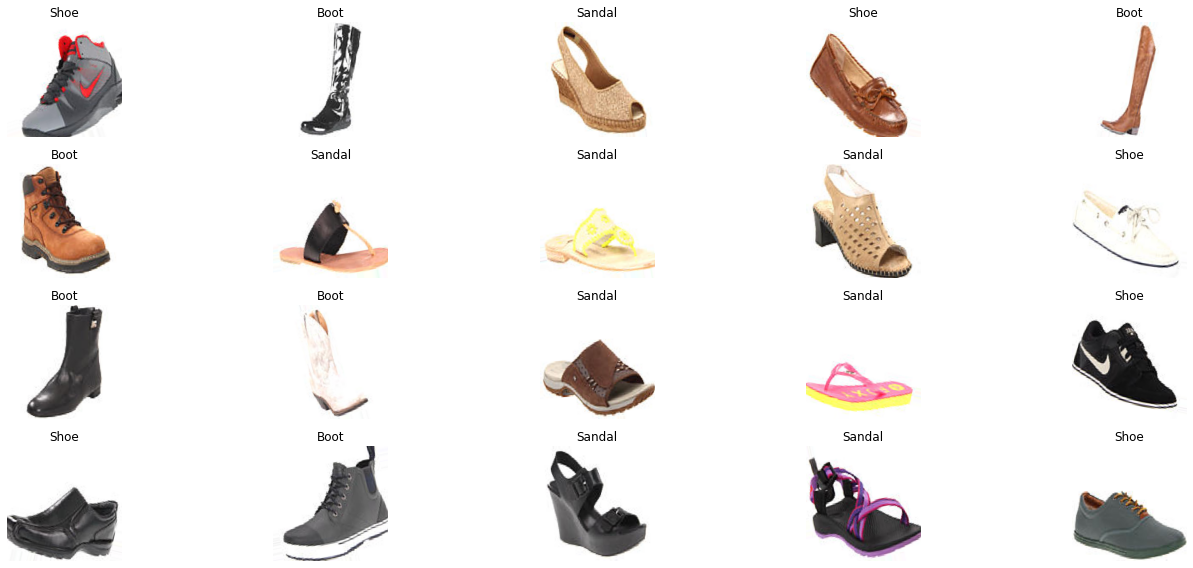

In [8]:
i=1
plt.figure(figsize=(20,8))
for images, labels in train_ds:
    index = np.random.randint(len(images))
    image, label = images[index], labels[index]

    plt.subplot(4,5, i)
    show_image(image, title=f"{class_names[int(label)]}")
    i+=1
    if i>=21: break

plt.tight_layout()
plt.show()

# **Model**

## **ResNet152V2**

In [9]:
# Set Name
name = "ResNet"

# Load Pretrained Model
base_model = ResNet152V2(include_top=False, weights='imagenet', input_shape=(256,256,3))
base_model.trainable = False

# Create Model
resnet = Sequential([
    base_model,
    GAP(),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(n_classes, activation='softmax')
], name=name)

# Compile Model
resnet.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# Callbacks
cbs = [
    EarlyStopping(patience=3, restore_best_weights=True),
    ModelCheckpoint(name + ".h5", save_best_only=True)
]

# # Train Model
# resnet.fit(
#     train_ds,
#     validation_data=valid_ds,
#     epochs=50,
#     callbacks=cbs
# )

234561536/234545216 [==============================] - 1s 0us/step


ResNet152V2 : 
* Accuracy : 98.06% - 97.13% Loss : 0.05 - 0.09 Epochs : 07

InceptionV3 : 
* Accuracy : 95.63% - 95.13% Loss : 0.12 - 0.13 Epochs : 05

Xception : 
* Accuracy : 97.18% - 96.53% Loss : 0.07 - 0.10 Epochs : 08

The results clearly show that **ResNet152V2** performs **best out of all**. And generally it **does perform out better** than all the others because it has **more parameters** than **Inception** and **Xception** both. But the good thing is, it is **faster than both of them**.

In [10]:
model = load_model('../input/shoe-sandal-boot-classifier/ResNet.h5')
model.summary()

Model: "ResNet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet152v2 (Functional)     (None, 8, 8, 2048)        58331648  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               524544    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 771  

In [11]:
model.evaluate(valid_ds) # it will be faster with GPU.

94/94 [==============================] - 69s 613ms/step - loss: 0.0745 - accuracy: 0.9757


[0.07449859380722046, 0.9756666421890259]

# **Predictions**

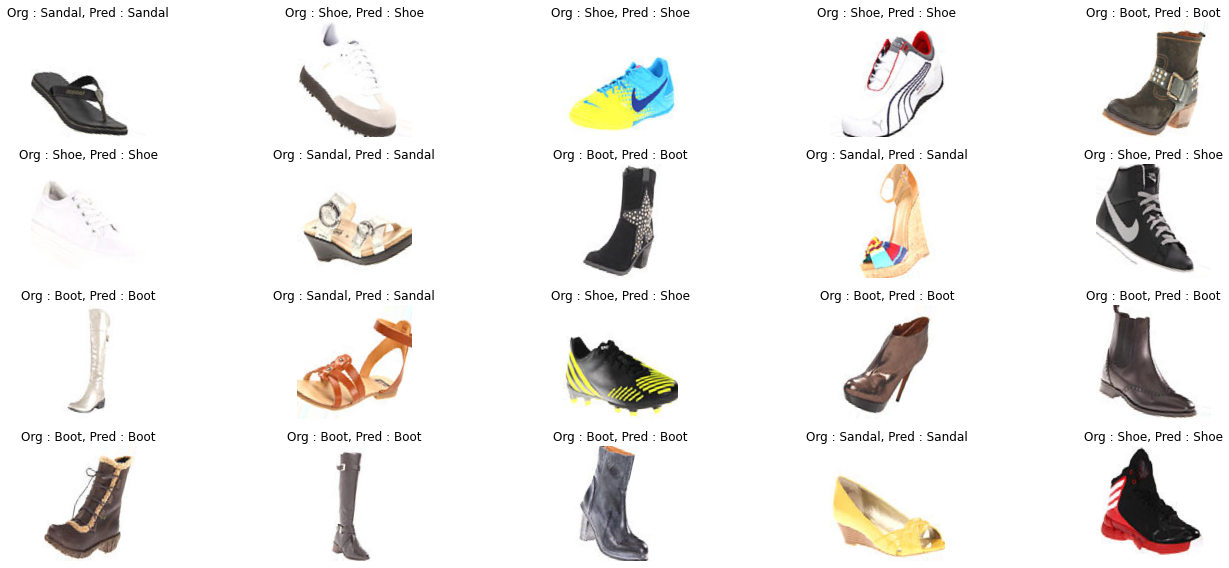

In [12]:
i=1
plt.figure(figsize=(20,8))
for images, labels in train_ds:
    index = np.random.randint(len(images))
    image, label = images[index], class_names[int(labels[index])]
    pred_label = class_names[np.argmax(model.predict(image[np.newaxis, ...]))]

    plt.subplot(4,5, i)
    show_image(image, title=f"Org : {label}, Pred : {pred_label}")
    i+=1
    if i>=21: break

plt.tight_layout()
plt.show()

All the **predictions** are **correct** and **that's amazing**. I expected at **least one** of the **prediction to be wrong**, but this is just **superb**. You can play with the model if you want to, the **model available in the data set**.


**Thank You**

$Suggestion :$ 
* Reducing the **model constraint** like dropout can result in **better performance**, but then you will have to take care of **overfitting**.

---

**DeepNets**

In [15]:
import os
import shutil

# Define the paths
source_folder = '../input/pictures'  # Update this path to your new dataset folder
writable_folder = '/kaggle/working/temp_pictures'  # A writable directory

# Create the writable directory if it doesn't exist
os.makedirs(writable_folder, exist_ok=True)

# List files in the source folder
source_files = os.listdir(source_folder)
print("Files in source folder before copying:", source_files)

# Copy and rename the file if necessary
for filename in source_files:
    if filename == 'all':
        old_path = os.path.join(source_folder, filename)
        new_path = os.path.join(writable_folder, 'all.jpg')  # Change the extension as needed
        shutil.copyfile(old_path, new_path)

# List files in the writable folder after copying and renaming
writable_files = os.listdir(writable_folder)
print("Files in writable folder after copying and renaming:", writable_files)

Files in source folder before copying: ['all']


IsADirectoryError: [Errno 21] Is a directory: '../input/pictures/all'

In [ ]:
import os

# Define the paths
source_folder = '../input/pictures'  # Update this path to your new dataset folder

# List files in the source folder
source_files = os.listdir(source_folder)
print("Items in source folder:", source_files)

# Filter out directories and list only files
source_files = [f for f in source_files if os.path.isfile(os.path.join(source_folder, f))]
print("Files in source folder after filtering directories:", source_files)

In [16]:
import os
import shutil

# Define the paths
source_folder = '../input/pictures'  # Update this path to your new dataset folder
writable_folder = '/kaggle/working/temp_pictures'  # A writable directory

# Create the writable directory if it doesn't exist
os.makedirs(writable_folder, exist_ok=True)

# List files in the source folder
source_files = os.listdir(source_folder)
print("Items in source folder before copying:", source_files)

# Filter out directories and list only files
source_files = [f for f in source_files if os.path.isfile(os.path.join(source_folder, f))]
print("Files in source folder after filtering directories:", source_files)

# Copy and rename the file if necessary
for filename in source_files:
    if filename == 'all':
        old_path = os.path.join(source_folder, filename)
        new_path = os.path.join(writable_folder, 'all.jpg')  # Change the extension as needed
        shutil.copyfile(old_path, new_path)

# List files in the writable folder after copying and renaming
writable_files = os.listdir(writable_folder)
print("Files in writable folder after copying and renaming:", writable_files)

Items in source folder before copying: ['all']
Files in source folder after filtering directories: []
Files in writable folder after copying and renaming: []


In [17]:
import os

# Define the paths
source_folder = '../input/pictures'  # Update this path to your new dataset folder
all_directory = os.path.join(source_folder, 'all')

# Check if "all" is a directory and list its contents
if os.path.isdir(all_directory):
    all_files = os.listdir(all_directory)
    print("Items in 'all' directory:", all_files)
    
    # Filter out directories and list only files
    all_files = [f for f in all_files if os.path.isfile(os.path.join(all_directory, f))]
    print("Files in 'all' directory after filtering directories:", all_files)
else:
    print("'all' is not a directory or does not exist.")

Items in 'all' directory: ['7981.jpg', '12666.jpg', '13288.jpg', '6234.jpg', '1269.jpg', '3863.jpg', '6241.jpg', '10304.jpg', '623.jpg', '2193.jpg', '14143.jpg', '11925.jpg', '3750.jpg', '11378.jpg', '2008.jpg', '10730.jpg', '5982.jpg', '7737.jpg', '2081.jpg', '14986.jpg', '10597.jpg', '6588.jpg', '10054.jpg', '12992.jpg', '7966.jpg', '3919.jpg', '6197.jpg', '10924.jpg', '6399.jpg', '9960.jpg', '13201.jpg', '3757.jpg', '9131.jpg', '13856.jpg', '9620.jpg', '9062.jpg', '4489.jpg', '3138.jpg', '10213.jpg', '3417.jpg', '6074.jpg', '5705.jpg', '8953.jpg', '764.jpg', '5307.jpg', '7894.jpg', '5039.jpg', '10305.jpg', '4407.jpg', '1700.jpg', '1786.jpg', '2907.jpg', '8930.jpg', '11138.jpg', '6324.jpg', '1075.jpg', '4969.jpg', '8983.jpg', '5584.jpg', '10627.jpg', '9697.jpg', '3501.jpg', '10037.jpg', '2863.jpg', '771.jpg', '8352.jpg', '208.jpg', '12167.jpg', '11868.jpg', '14167.jpg', '4640.jpg', '7222.jpg', '13839.jpg', '5333.jpg', '4125.jpg', '14312.jpg', '6560.jpg', '2628.jpg', '10162.jpg', '810

In [20]:
import os
import shutil

# Define the paths
source_folder = '../input/pictures'  # Update this path to your new dataset folder
all_directory = os.path.join(source_folder, 'all')
writable_folder = '/kaggle/working/temp_pictures'  # A writable directory

# Create the writable directory if it doesn't exist
os.makedirs(writable_folder, exist_ok=True)

# Check if "all" is a directory and list its contents
if os.path.isdir(all_directory):
    all_files = os.listdir(all_directory)
    print("Items in 'all' directory before copying:", all_files)
    
    # Filter out directories and list only files
    all_files = [f for f in all_files if os.path.isfile(os.path.join(all_directory, f))]
    print("Files in 'all' directory after filtering directories:", all_files)
    
    # Copy and rename the files if necessary
    for filename in all_files:
        old_path = os.path.join(all_directory, filename)
        new_path = os.path.join(writable_folder, filename)  # Keep the same name or change the extension as needed
        shutil.copyfile(old_path, new_path)
else:
    print("'all' is not a directory or does not exist.")

# List files in the writable folder after copying and renaming
writable_files = os.listdir(writable_folder)
print("Files in writable folder after copying and renaming:", writable_files)

Items in 'all' directory before copying: ['7981.jpg', '12666.jpg', '13288.jpg', '6234.jpg', '1269.jpg', '3863.jpg', '6241.jpg', '10304.jpg', '623.jpg', '2193.jpg', '14143.jpg', '11925.jpg', '3750.jpg', '11378.jpg', '2008.jpg', '10730.jpg', '5982.jpg', '7737.jpg', '2081.jpg', '14986.jpg', '10597.jpg', '6588.jpg', '10054.jpg', '12992.jpg', '7966.jpg', '3919.jpg', '6197.jpg', '10924.jpg', '6399.jpg', '9960.jpg', '13201.jpg', '3757.jpg', '9131.jpg', '13856.jpg', '9620.jpg', '9062.jpg', '4489.jpg', '3138.jpg', '10213.jpg', '3417.jpg', '6074.jpg', '5705.jpg', '8953.jpg', '764.jpg', '5307.jpg', '7894.jpg', '5039.jpg', '10305.jpg', '4407.jpg', '1700.jpg', '1786.jpg', '2907.jpg', '8930.jpg', '11138.jpg', '6324.jpg', '1075.jpg', '4969.jpg', '8983.jpg', '5584.jpg', '10627.jpg', '9697.jpg', '3501.jpg', '10037.jpg', '2863.jpg', '771.jpg', '8352.jpg', '208.jpg', '12167.jpg', '11868.jpg', '14167.jpg', '4640.jpg', '7222.jpg', '13839.jpg', '5333.jpg', '4125.jpg', '14312.jpg', '6560.jpg', '2628.jpg', '1

In [21]:
import os
import shutil
import numpy as np
from keras.preprocessing.image import load_img, img_to_array
from keras.models import load_model

# Load the pre-trained model
model = load_model('../input/shoe-sandal-boot-classifier/ResNet.h5')

# Define the class names
class_names = ['Boot', 'Sandal', 'Shoe']

# Define the paths
source_folder = '/kaggle/working/temp_pictures'  # Use the writable directory
destination_folder = '/kaggle/working/new_sorted'

# Create destination folders if they don't exist
for class_name in class_names:
    os.makedirs(os.path.join(destination_folder, class_name), exist_ok=True)

# Function to predict the class of an image
def predict_image_class(image_path):
    image = load_img(image_path, target_size=(256, 256))
    image_array = img_to_array(image) / 255.0
    image_array = np.expand_dims(image_array, axis=0)
    prediction = model.predict(image_array)
    predicted_class = class_names[np.argmax(prediction)]
    return predicted_class

# Check if source folder contains images
source_files = os.listdir(source_folder)
if not source_files:
    print("No images found in the source folder.")
else:
    print(f"Found {len(source_files)} items in the source folder.")
    print("Files in source folder:", source_files)

# Loop through each image in the source folder
for filename in source_files:
    if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
        image_path = os.path.join(source_folder, filename)
        try:
            predicted_class = predict_image_class(image_path)
            destination_path = os.path.join(destination_folder, predicted_class, filename)
            shutil.move(image_path, destination_path)
            print(f"Moved {filename} to {predicted_class} folder")
        except Exception as e:
            print(f"Error processing {filename}: {e}")
    else:
        print(f"Skipped {filename}, not a valid image file.")

print("All images have been sorted.")

Found 15000 items in the source folder.
Files in source folder: ['10385.jpg', '5445.jpg', '5366.jpg', '1150.jpg', '10584.jpg', '12837.jpg', '7943.jpg', '13329.jpg', '14727.jpg', '8009.jpg', '11081.jpg', '1445.jpg', '11589.jpg', '13170.jpg', '974.jpg', '11839.jpg', '8029.jpg', '777.jpg', '10486.jpg', '9082.jpg', '4296.jpg', '5432.jpg', '5841.jpg', '5905.jpg', '10789.jpg', '12312.jpg', '2791.jpg', '829.jpg', '3850.jpg', '13048.jpg', '12660.jpg', '1043.jpg', '5689.jpg', '10356.jpg', '10131.jpg', '223.jpg', '6773.jpg', '9620.jpg', '5595.jpg', '7592.jpg', '11364.jpg', '462.jpg', '5714.jpg', '2235.jpg', '14198.jpg', '12822.jpg', '9028.jpg', '5205.jpg', '8834.jpg', '6736.jpg', '12311.jpg', '6513.jpg', '818.jpg', '5871.jpg', '12302.jpg', '12914.jpg', '2121.jpg', '10771.jpg', '9197.jpg', '5646.jpg', '201.jpg', '5163.jpg', '1702.jpg', '619.jpg', '3895.jpg', '8614.jpg', '14482.jpg', '9268.jpg', '11725.jpg', '13124.jpg', '9389.jpg', '7819.jpg', '10495.jpg', '13801.jpg', '1730.jpg', '4047.jpg', '75

In [22]:
import os
import random
import matplotlib.pyplot as plt
from keras.preprocessing.image import load_img, img_to_array

# Define the paths
sorted_dataset_folder = '/kaggle/working/new_sorted'
class_names = ['Boot', 'Sandal', 'Shoe']

In [23]:
# Function to randomly select images from each class
def select_sample_images(sorted_dataset_folder, class_names, num_samples=5):
    sample_images = {}
    for class_name in class_names:
        class_folder = os.path.join(sorted_dataset_folder, class_name)
        all_images = os.listdir(class_folder)
        selected_images = random.sample(all_images, min(num_samples, len(all_images)))
        sample_images[class_name] = [os.path.join(class_folder, img) for img in selected_images]
    return sample_images

# Select sample images
num_samples = 5  # Number of samples to select from each class
sample_images = select_sample_images(sorted_dataset_folder, class_names, num_samples)
print("Sample images selected:", sample_images)

Sample images selected: {'Boot': ['/kaggle/working/new_sorted/Boot/9679.jpg', '/kaggle/working/new_sorted/Boot/10527.jpg', '/kaggle/working/new_sorted/Boot/9717.jpg', '/kaggle/working/new_sorted/Boot/14784.jpg', '/kaggle/working/new_sorted/Boot/6496.jpg'], 'Sandal': ['/kaggle/working/new_sorted/Sandal/5643.jpg', '/kaggle/working/new_sorted/Sandal/9463.jpg', '/kaggle/working/new_sorted/Sandal/14417.jpg', '/kaggle/working/new_sorted/Sandal/12793.jpg', '/kaggle/working/new_sorted/Sandal/7831.jpg'], 'Shoe': ['/kaggle/working/new_sorted/Shoe/7888.jpg', '/kaggle/working/new_sorted/Shoe/6408.jpg', '/kaggle/working/new_sorted/Shoe/3755.jpg', '/kaggle/working/new_sorted/Shoe/12691.jpg', '/kaggle/working/new_sorted/Shoe/4398.jpg']}


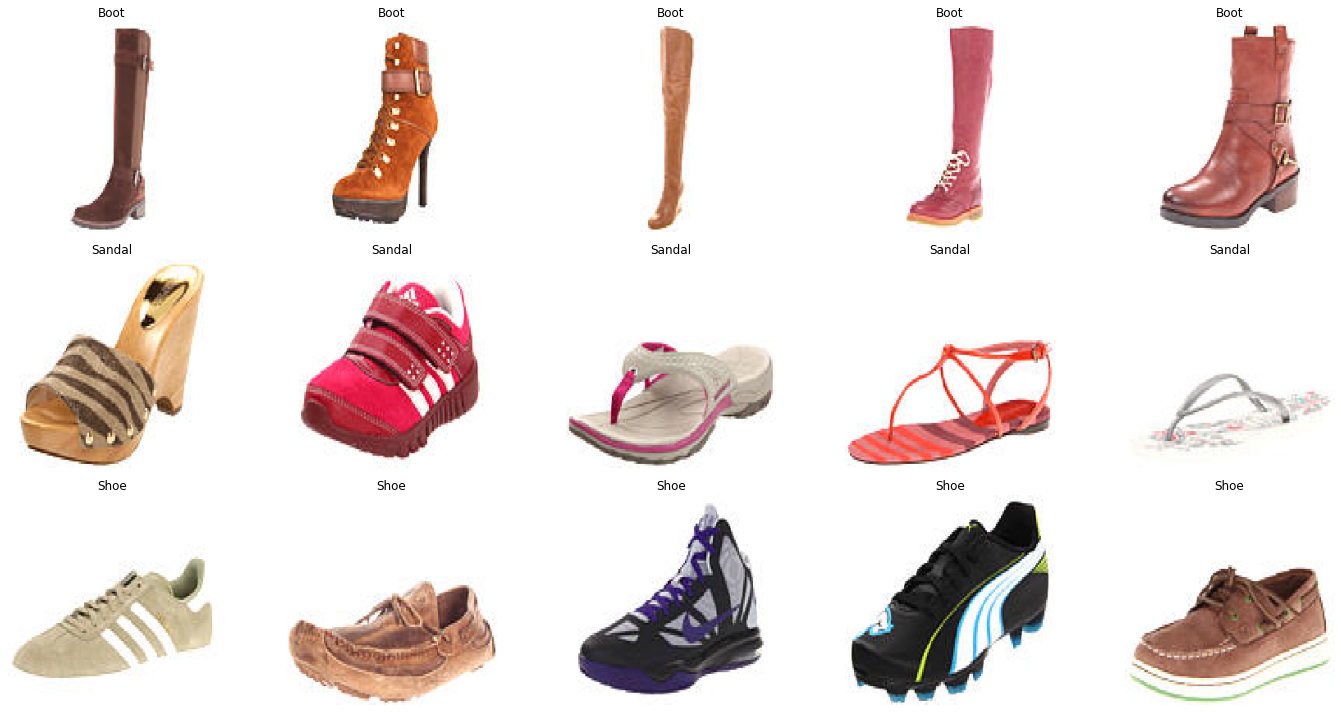

In [24]:
# Function to display images
def show_image(image_path, title=None):
    image = load_img(image_path, target_size=(256, 256))
    plt.imshow(image)
    plt.title(title)
    plt.axis('off')

# Display the selected images
plt.figure(figsize=(20, 10))
i = 1
for class_name, images in sample_images.items():
    for image_path in images:
        plt.subplot(len(class_names), num_samples, i)
        show_image(image_path, title=class_name)
        i += 1

plt.tight_layout()
plt.show()